*This is Part 2 in the Practical Pandas Series, where I work through a data analysis problem from start to finish.*

It's a misconception that we can cleanly separate the data analysis pipeline into a linear
sequence of steps from

1. data acqusition
2. data tidying
3. exploratory analysis
4. model building
5. production

As you work through a problem you'll realize, "I need this other bit of data", or "this would be easier if I stored the data this way", or more commonly "strange, that's not supposed to happen".

We'll follow up our [last post](http://tomaugspurger.github.io/blog/2014/08/26/practical-pandas-part-1-reading-the-data/) by circling back to cleaning up our data set, and fetching some more data.
Here's a reminder of where we were.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_hdf('data/cycle_store.h5', key='merged')
df.head()

,Time,Ride Time,Ride Time (secs),Stopped Time,Stopped Time (secs),Latitude,Longitude,Elevation (feet),Distance (miles),Speed (mph),Pace,Pace (secs),Average Speed (mph),Average Pace,Average Pace (secs),Ascent (feet),Descent (feet),Calories,ride_id
0,2013-08-01 07:07:10,2014-09-02 00:00:01,1.1,2014-09-02,0,41.703753,-91.609892,963,0.00,2.88,2014-09-02 00:20:51,1251,0.00,2014-09-02 00:00:00,0,0,0,0,0
1,2013-08-01 07:07:17,2014-09-02 00:00:08,8.2,2014-09-02,0,41.703825,-91.609835,852,0.01,2.88,2014-09-02 00:20:51,1251,2.56,2014-09-02 00:23:27,1407,0,129,0,0
2,2013-08-01 07:07:22,2014-09-02 00:00:13,13.2,2014-09-02,0,41.703858,-91.609814,789,0.01,2.88,2014-09-02 00:20:51,1251,2.27,2014-09-02 00:26:27,1587,0,173,0,0
3,2013-08-01 07:07:27,2014-09-02 00:00:18,18.2,2014-09-02,0,41.703943,-91.610090,787,0.02,6.60,2014-09-02 00:09:06,546,4.70,2014-09-02 00:12:47,767,0,173,1,0
4,2013-08-01 07:07:40,2014-09-02 00:00:31,31.2,2014-09-02,0,41.704381,-91.610258,788,0.06,9.50,2014-09-02 00:06:19,379,6.37,2014-09-02 00:09:26,566,0,173,2,0


Because of a [bug](https://github.com/pydata/pandas/issues/8189) in pandas, we lost our timzone information when we filled in our missing values. Until that's fixed we'll have to manually add back the timezone info and convert.

I like to keep my DataFrame columns as valid python identifiers.
Let's define a helper function to rename the columns. We also have a few redundant columns that we can drop.

In [2]:
df = df.drop(['Ride Time', 'Stopped Time', 'Pace', 'Average Pace'], axis=1)

def renamer(name):
    for char in ['(', ')']:
        name = name.replace(char, '')
    name = name.replace(' ', '_')
    name = name.lower()
    return name

df = df.rename(columns=renamer)
list(df.columns)

['time',
 'ride_time_secs',
 'stopped_time_secs',
 'latitude',
 'longitude',
 'elevation_feet',
 'distance_miles',
 'speed_mph',
 'pace_secs',
 'average_speed_mph',
 'average_pace_secs',
 'ascent_feet',
 'descent_feet',
 'calories',
 'ride_id']

### Do you trust the data?

Remember that I needed to manually start and stop the timer each ride, which natuarlly means that I messed this up at least once. Let's see if we can figure out the rides where I messed things up.
The first heuristic we'll use is checking to see if I moved at all.

All of my rides should have take roughly the same about of time. Let's get an idea of how the distribution of ride times look. We'll look at both the ride time and the time I spent stopped.
If I spend a long time in the same place, there's a good chance that I finished my ride and forgot to stop the timer.

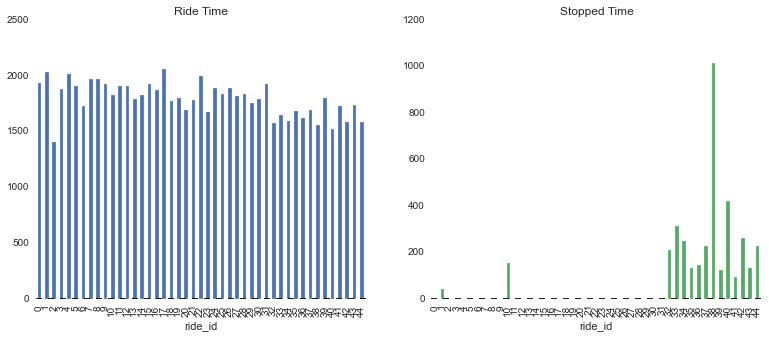

In [3]:
time_pal = sns.color_palette(n_colors=2)

# Plot it in mintues
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))

# max to get the last observation per ride since we know these are increasing
times = df.groupby('ride_id')[['stopped_time_secs', 'ride_time_secs']].max()
times['ride_time_secs'].plot(kind='bar', ax=axes[0], color=time_pal[0])
axes[0].set_title("Ride Time")

times['stopped_time_secs'].plot(kind='bar', ax=axes[1], color=time_pal[1])
axes[1].set_title("Stopped Time")

Let's dig into that spike in the stopped time. We'll get it's ride id with the `Series.argmax` method.

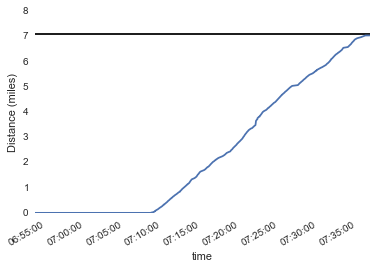

In [4]:
idx = times.stopped_time_secs.argmax()
long_stop = df[df.ride_id == idx]

ax = long_stop.set_index('time')['distance_miles'].plot()
avg_distance = df.groupby('ride_id').distance_miles.max().mean()
ax.set_ylabel("Distance (miles)")
ax.hlines(avg_distance, *ax.get_xlim())

So it looks like I started my timer, sat around for about 15 minutes, and then continued with my normal ride (I verified that by plotting the average distance travelled per ride, and it was right on target).

We can use most of the columns fine, it's just the the `time` column we need to be careful with. Let's
make an adjusted time column `time_adj` that accounts for the stopped time.

In [5]:
import datetime

def as_timedelta(x):
    return datetime.timedelta(0, x // 1, x % 1)

df['time_adj'] = df.time - df.stopped_time_secs.apply(as_timedelta)
df.head()

,time,ride_time_secs,stopped_time_secs,latitude,longitude,elevation_feet,distance_miles,speed_mph,pace_secs,average_speed_mph,average_pace_secs,ascent_feet,descent_feet,calories,ride_id,time_adj
0,2013-08-01 07:07:10,1.1,0,41.703753,-91.609892,963,0.00,2.88,1251,0.00,0,0,0,0,0,2013-08-01 07:07:10
1,2013-08-01 07:07:17,8.2,0,41.703825,-91.609835,852,0.01,2.88,1251,2.56,1407,0,129,0,0,2013-08-01 07:07:17
2,2013-08-01 07:07:22,13.2,0,41.703858,-91.609814,789,0.01,2.88,1251,2.27,1587,0,173,0,0,2013-08-01 07:07:22
3,2013-08-01 07:07:27,18.2,0,41.703943,-91.610090,787,0.02,6.60,546,4.70,767,0,173,1,0,2013-08-01 07:07:27
4,2013-08-01 07:07:40,31.2,0,41.704381,-91.610258,788,0.06,9.50,379,6.37,566,0,173,2,0,2013-08-01 07:07:40


When we start using the actual GPS data, we may need to do some smoothing.
These are just readings from my iPhone, which probably aren't that accurate. [Kalman filters](http://en.wikipedia.org/wiki/Kalman_filter), which I learned about in my econometrics class, are commonly used for this purpose.
But I think that's good enough for now. 

### Getting More Data

I'm interested in explaining the variation in how long it took me to make the ride.
I hypothesize that the weather may have had something to do with it. We'll fetch data from [forecas.io](http://forecast.io) using their [API](https://developer.forecast.io) to get the weather conditions at the time of each ride.


I looked at the [forecast.io documentation](https://developer.forecast.io/docs/v2), and noticed that the API will require a timezone. We could proceed in two ways

1. Set `df.time` to be the index (a DatetimeIndex). Then localize with `df.tz_localize`
2. Pass `df.time` through the DatetimeIndex constructor to set the timezone, and set that to be a column in df.

Ideally we'd go with 1. Pandas has a lot of great additoinal functionality to offer when you have a DatetimeIndex (such as `resample`).
However, this conflicts with the desire to have a unique index with this specific dataset. The times recorded are at the second frequency, but there are occasionally multiple readings in a second.

In [6]:
# should be 0 if there are no repeats.
len(df.time) - len(df.time.unique())

114

So we'll go with #2, running the `time` column through the `DatetimeIndex` constructor, which has a `tz` (timezone) parameter, and placing that in a 'time' column. I'm in the `US/Central` timezone.

In [7]:
df['time'] = pd.DatetimeIndex(df.time, tz='US/Central')
df.head()

,time,ride_time_secs,stopped_time_secs,latitude,longitude,elevation_feet,distance_miles,speed_mph,pace_secs,average_speed_mph,average_pace_secs,ascent_feet,descent_feet,calories,ride_id,time_adj
0,2013-08-01 07:07:10-05:00,1.1,0,41.703753,-91.609892,963,0.00,2.88,1251,0.00,0,0,0,0,0,2013-08-01 07:07:10
1,2013-08-01 07:07:17-05:00,8.2,0,41.703825,-91.609835,852,0.01,2.88,1251,2.56,1407,0,129,0,0,2013-08-01 07:07:17
2,2013-08-01 07:07:22-05:00,13.2,0,41.703858,-91.609814,789,0.01,2.88,1251,2.27,1587,0,173,0,0,2013-08-01 07:07:22
3,2013-08-01 07:07:27-05:00,18.2,0,41.703943,-91.610090,787,0.02,6.60,546,4.70,767,0,173,1,0,2013-08-01 07:07:27
4,2013-08-01 07:07:40-05:00,31.2,0,41.704381,-91.610258,788,0.06,9.50,379,6.37,566,0,173,2,0,2013-08-01 07:07:40


There's nothing specific to pandas here, but knowing the basics of calling an API and parsing the response is still useful.
We'll use [requests](http://docs.python-requests.org/en/latest/) to make the
API call. You'll need to register for you own API key. I keep mine in a JSON file in my Dropbox bin folder.

For this specific call we need to give the Latitude, Longitude, and Time that we want the weather for.
We fill in those to a url with the format `https://api.forecast.io/forecast/{key}/{Latitude},{Longitude},{Time}`.

In [8]:
import json
import requests

with open('/Users/tom/Dropbox/bin/api-keys.txt') as f:
    key = json.load(f)['forecast.io']

url = "https://api.forecast.io/forecast/{key}/{Latitude},{Longitude},{Time}"

vals = df.loc[0, ['latitude', 'longitude', 'time']].rename(lambda x: x.title()).to_dict()
vals['Time'] = str(vals['Time']).replace(' ', 'T')
vals['key'] = key

r = requests.get(url.format(**vals))
resp = r.json()

In [9]:
resp.keys()

dict_keys(['timezone', 'longitude', 'hourly', 'offset', 'currently', 'daily', 'latitude', 'flags'])

Here's the plan. For each ride, we'll get the current conditions at the time, latitude, and longitude of departure.
We'll use those values for the entirety of that ride.

I'm a bit concerned about the variance of some quantities from the weather data (like the windspeed and bearing). This would be something to look into for a serious analysis. If the quantities are highly variable you would want to take a rolling average over more datapoints. `forecast.io` limits you to 1,000 API calls per day though (at the free tier), so we'll just stick with one request per ride.

In [10]:
def get_weather(df, ride_id, key):
    """
    Get the current weather conditions for for a ride at the time of departure.
    """
    url = "https://api.forecast.io/forecast/{key}/{Latitude},{Longitude},{Time}"
    vals = df.query("ride_id == @ride_id").iloc[0][['latitude',
               'longitude', 'time']].rename(lambda x: x.title()).to_dict()
    vals['key'] = key
    vals['Time'] = str(vals['Time']).replace(' ', 'T')
    r = requests.get(url.format(**vals))
    resp = r.json()['currently']
    return resp

Let's test it out:

In [ ]:
get_weather(df, df.ride_id.unique()[0], key)

{'apparentTemperature': 61.62,
 'precipProbability': 0,
 'summary': 'Clear',
 'cloudCover': 0,
 'windSpeed': 2.77,
 'windBearing': 282,
 'dewPoint': 58.66,
 'pressure': 1017.62,
 'icon': 'clear-day',
 'humidity': 0.9,
 'visibility': 8.89,
 'time': 1375358830,
 'temperature': 61.62,
 'precipIntensity': 0}

Now do that for each `ride_id`, and store the result in a DataFrame

In [ ]:
conditions = [get_weather(df, ride_id, key) for ride_id
              in df.ride_id.unique()]
weather = pd.DataFrame(conditions)
weather.head()

Let's fixup the dtype on the `time` column. We need to convert from the seconds to a datetime.
Then handle the timezone like before. This is returned in 'UTC', so we'll bring it back to
my local time with `.tz_convert`.

In [ ]:
weather['time'] = pd.DatetimeIndex(pd.to_datetime(weather.time, unit='s'), tz='UTC').\
                     tz_convert('US/Central')

Now we can merge the two DataFrames `weather` and `df`. In this case it's quite simple since the share a single column, `time`. Pandas behaves exactly as you'd expect, merging on the provided column.
We take the `outer` join since we only have weather information for the first obervation of each ride.
We'll fill those values forward for the entirety of the ride.

I don't just call `with_weather.fillna()` since the non-weather columns have `NaN`s that we may want to treat separately.

In [ ]:
with_weather = pd.merge(df, weather, on='time', how='outer')
print(with_weather.time.dtype)
with_weather[weather.columns] = with_weather[weather.columns].fillna(method='ffill')
print(with_weather.time.dtype)

In [ ]:
with_weather.time.head()

In [ ]:
with_weather.time.head()

With that done, let's write `with_weather` out to disk. We'll get a Performance Warning since some of the columns are text, which are relatively slow for HDF5, but it's not a problem worht worrying about for a dataset this small.
If you needed you could encode the text ones as integers with `pd.factorize`, write the integers out the the HDF5 store, and store the mapping from integer to text description elsewhere.

In [ ]:
with_weather.to_hdf('data/cycle_store.h5', key='with_weather', append=False, format='table')
weather.to_hdf('data/cycle_store.h5', key='weather', append=False, format='table')

### A bit of Exploring

We've done a lot of data wrangling with a notable lack of pretty pictures to look at. Let's fix that.

In [ ]:
sns.puppyplot()

For some other (less) pretty pictures, let's visualize some of the weather data we collected.

In [ ]:
sns.set(style="white")

cols = ['temperature', 'apparentTemperature', 'humidity', 'dewPoint', 'pressure']
# 'pressure', 'windBearing', 'windSpeed']].reset_index(drop=True))

g = sns.PairGrid(weather.reset_index()[cols])
                          
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)

Not bad! [Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/) makes exploring these relationships very easy.

Let's also take a look at the wind data. I'm not a metorologist, but I saw a plot one time that's like a histogram for wind directions, but plotted on a [polar axis](http://en.wikipedia.org/wiki/Polar_coordinate_system) (brings back memories of Calc II). Fortunately for us, matplotlib handles polar plots pretty easily, we just have to setup the
axes and hand it the values as radians.

In [ ]:
ax = plt.subplot(polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')

bins = np.arange(0, 361, 30)
ax.hist(np.radians(weather.windBearing.dropna()), bins=np.radians(bins))
ax.set_title("Direction of Wind Origin")

`windBearing` represent the direction the wind is coming *from* so the most common direction is from the S/SW. It may be clearer to flip that around to represent the wind direction; I'm not sure what's standard.

If we were feeling ambitious, we could try to color the wedges by the windspeed. Let's give it a shot!

We'll need to get the average wind speed in each of our `bins` from above. This is clearly a `groupby`, but what excatly is the grouper? This is where pandas `Catagorical` comes in handy. We'll [`pd.cut`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html) the wind direction, and group the wind data by that.

In [ ]:
wind = weather[['windSpeed', 'windBearing']].dropna()

ct = pd.cut(wind.windBearing, bins)
speeds = wind.groupby(ct)['windSpeed'].mean()
colors = plt.cm.BuGn(speeds.div(speeds.max()))

I map the speeds to colors with one of matplotlib's colormaps. It expects values in `[0, 1]`, so
we normalize the speeds by dividing by the maximum.

`hist` doesn't take a cmap argument, and I couldn't get `color` to work, so we'll just plot it like before,
and then modify the color of the patches after the fact.

In [ ]:
fig = plt.figure()
ax = plt.subplot(polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')

bins = np.arange(0, 360, 30)
ax.hist(np.radians(weather.windBearing.dropna()), bins=np.radians(bins))

for p, color in zip(ax.patches, colors):
    p.set_facecolor(color)

ax.set_title("Direction of Wind Origin")

Colorbars are tricky in matplotlib (at least for me). So I'm going to leave it at darker is stronger wind.

That's all for now. Come back next time for some exploratory analysis, and if we're lucky, some maps!